In [1]:
import geoplot as gplt
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import requests
%matplotlib inline

In [30]:
from shapely.geometry import Point

collisions = pd.read_csv("https://github.com/ResidentMario/geoplot-data/raw/master/nyc_collisions/NYPD_Motor_Vehicle_Collisions_2016.csv", index_col=0)
collisions = collisions[collisions['BOROUGH'].notnull()]

fatal_collisions = collisions[collisions["NUMBER OF PERSONS KILLED"] > 0]

def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return Point(0, 0)
    else:
        return Point(long, lat)

fatal_collisions = gpd.GeoDataFrame(fatal_collisions,
                                    geometry=fatal_collisions.apply(pointify, axis='columns'))
fatal_collisions = fatal_collisions[fatal_collisions.geometry.map(lambda srs: not (srs.x == 0))]
fatal_collisions = fatal_collisions[fatal_collisions['DATE'].map(lambda day: "2016" in day)]

fatal_collisons_geojson = fatal_collisions.loc[:, ['BOROUGH', 'NUMBER OF PERSONS KILLED', 'geometry']].to_json()

with open("nyc-fatal-traffic-collisions.geojson", "w") as f:
    f.write(fatal_collisons_geojson)

    
injurious_collisions = collisions[collisions["NUMBER OF PERSONS INJURED"] > 0]
injurious_collisions = gpd.GeoDataFrame(injurious_collisions,
                                        geometry=injurious_collisions.apply(pointify, axis='columns'))
injurious_collisions = injurious_collisions[injurious_collisions.geometry.map(lambda srs: not (srs.x == 0))]
injurious_collisions = injurious_collisions[injurious_collisions['DATE'].map(lambda day: "2016" in day)]
fatal_collisons_geojson = fatal_collisions.loc[:, ['BOROUGH', 'NUMBER OF PERSONS INJURED', 'geometry']].to_json()

with open("nyc-injurious-traffic-collisions.geojson", "w") as f:
    f.write(fatal_collisons_geojson)

In [39]:
with open("nyc-boroughs.geojson", "w") as f:
    f.write(requests.get("https://github.com/ResidentMario/geoplot-data/raw/master/nyc_boroughs/boroughs.geojson").text)

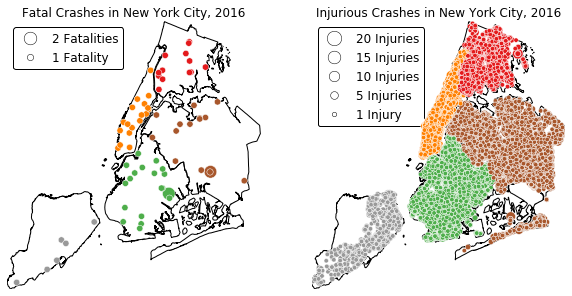

In [42]:
import matplotlib.pyplot as plt
import geoplot.crs as gcrs

boroughs = gpd.read_file("nyc-boroughs.geojson")

fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121, projection=gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))
gplt.polyplot(boroughs, ax=ax1, projection=gcrs.AlbersEqualArea())
gplt.pointplot(fatal_collisions, projection=gcrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS KILLED', limits=(2, 8),
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[2, 1], legend_labels=['2 Fatalities', '1 Fatality'],
               ax=ax1)
plt.title("Fatal Crashes in New York City, 2016")

ax2 = plt.subplot(122, projection=gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))
gplt.polyplot(boroughs, ax=ax2, projection=gcrs.AlbersEqualArea())
gplt.pointplot(injurious_collisions, projection=gcrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS INJURED', limits=(1, 10),
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[20, 15, 10, 5, 1],
               legend_labels=['20 Injuries', '15 Injuries', '10 Injuries', '5 Injuries', '1 Injury'],
               ax=ax2)
plt.title("Injurious Crashes in New York City, 2016")

In [43]:
del fatal_collisions
del injurious_collisions

In [44]:
cities = gpd.read_file("/Users/Honors/Desktop/geoplot-data/cities/citiesx010g.shp")

In [53]:
with open("us-cities.geojson", "w") as f:
    f.write(cities.query('POP_2010 > 10000').loc[:, ['STATE', 'POP_2010', 'ELEV_IN_FT', 'geometry']].to_json())

In [60]:
usa = gpd.read_file("/Users/Honors/Desktop/geoplot-data/united_states/usa.geojson")
contiguous_usa = usa[~usa['adm1_code'].isin(['USA-3517', 'USA-3563'])]

In [64]:
with open("contiguous-usa.geojson", "w") as f:
    f.write(contiguous_usa.loc[:, ['adm1_code', 'geometry']].to_json())

In [67]:
census_2010 = gpd.read_file("/Users/Honors/Desktop/geoplot-data/ny_census_2010/cty036.shp")

In [72]:
with open("nyc-census-partial.geojson", "w") as f:
    f.write(census_2010.loc[:, ['WHITE', 'POP2000', 'geometry']].to_json())

In [77]:
import numpy as np

precincts = gpd.read_file("/Users/Honors/Desktop/geoplot-data/nyc_precincts/Police Precincts.geojson")
precincts['precinct'] = precincts['precinct'].astype(int)
tickets = pd.read_csv("/Users/Honors/Desktop/geoplot-data/nyc_parking/Aggregated_Parking_Violations_-_Fiscal_Year_2016.csv", index_col=0)
# Due to an error on my part, the result is not quite grouped correctly. The following code bit fixes the issue.
tickets = tickets.groupby(['Precinct', 'State Name'])[['Count']].sum().reset_index()
tickets = tickets[tickets['Precinct'].isin(precincts['precinct'].values)]
tickets['Precinct'] = tickets['Precinct'].astype(int)
boroughs = gpd.read_file("/Users/Honors/Desktop/geoplot-data/nyc_boroughs/boroughs.geojson")

state_names = np.unique(tickets['State Name'].values)
precinct_ticket_totals = tickets.groupby('Precinct').sum()
state_ticket_totals = tickets.groupby('State Name').sum()
precincts = precincts.set_index('precinct')


# The following function automatically munges the data as appropriate for a particular state.
def tickets_by_precinct(state):
    """
    Returns data with the percentage of tickets issued in the given census tract out of all tickets issued to that
    *precinct*
    """
    state_tickets = tickets[tickets['State Name'] == state].set_index('Precinct')

    def get_precinct_ticket_percentage(srs):
        precinct = srs.name
        state_count = srs['Count']
        precinct_count = precinct_ticket_totals.loc[precinct]
        return state_count / precinct_count

    precinct_ticket_percentages = state_tickets.apply(get_precinct_ticket_percentage, axis='columns')

    def get_geom(precinct_num):
        return precincts.loc[precinct_num].geometry

    geom = precinct_ticket_percentages.index.map(get_geom)
    geo_data = gpd.GeoDataFrame(data=precinct_ticket_percentages, geometry=geom)
    return geo_data

In [83]:
tickets_by_precinct_melt = gpd.GeoDataFrame(
    geometry=tickets_by_precinct('New York').geometry,
    index=tickets_by_precinct('New York').index
)

In [89]:
tickets_by_precinct_melt['ny'] = tickets_by_precinct('New York').Count
tickets_by_precinct_melt['nj'] = tickets_by_precinct('New Jersey').Count
tickets_by_precinct_melt['ct'] = tickets_by_precinct('Connecticut').Count
tickets_by_precinct_melt['pa'] = tickets_by_precinct('Pennsylvania').Count

In [91]:
with open("nyc-parking-tickets-sample.geojson", "w") as f:
    f.write(tickets_by_precinct_melt.to_json())

In [93]:
dc_roads = gpd.read_file("/Users/Honors/Desktop/geoplot-data/us_roads/District_Sections.shp")

In [97]:
with open("dc-roads.geojson", "w") as f:
    f.write(dc_roads.loc[:, ['aadt', 'geometry']].to_json())

In [98]:
%ls

boroughs.geojson
build.ipynb
contiguous-usa.geojson
dc-road-aadt.geojson
fatal-traffic-collisions-nyc.geojson
injurious-traffic-collisions-nyc.geojson
nyc-census-2010-partial.geojson
nyc-police-precincts.geojson
nyc-ticket-distributions-from-four-states.geojson
obesity_by_state.tsv
us-cities-with-at-least-10000-residents.geojson


In [106]:
boston_zip_codes = gpd.read_file("/Users/Honors/Desktop/geoplot-data/boston_airbnb/ZIPCODES_NT_POLY.shp")
listings = pd.read_csv("~/Desktop/geoplot-data/boston_airbnb/listings.csv")

In [108]:
airbnbs = listings[['latitude', 'longitude']].apply(lambda srs: Point(srs['longitude'], srs['latitude']),
                                                    axis='columns')
listings = gpd.GeoDataFrame(data=listings, geometry=airbnbs)
listings['price'] = listings['price'].map(
    lambda p: p[1:].replace(".", "").replace(",", "") if (not isinstance(p, float)) else np.nan).astype(float)
listings['price'] = list(map(lambda p: float(p) / 100, listings['price']))
listings = listings[listings['price'].notnull()]
listings['zipcode'] = listings['zipcode'].map(lambda z: float(str(z).replace("-", "").split(" ")[0]))
listings = listings[listings['zipcode'].notnull()]
boston_zip_codes['POSTCODE'] = boston_zip_codes['POSTCODE'].map(lambda p: float(p[1:]) if p[0] == '0' else float(p))
boston_zip_codes = boston_zip_codes.drop_duplicates('POSTCODE')
boston_zip_codes = boston_zip_codes.set_index("POSTCODE")
listings = listings[~listings['zipcode'].isin([2218.0, 21341704.0])]
boston_zip_codes = boston_zip_codes.to_crs(epsg=4326)

In [115]:
with open("boston-zip-codes.geojson", "w") as f:
    f.write(boston_zip_codes.loc[:, ['geometry']].to_json())

In [123]:
with open("boston-airbnb-listings.geojson", "w") as f:
    f.write(listings.loc[:, ['price', 'geometry']].to_json())

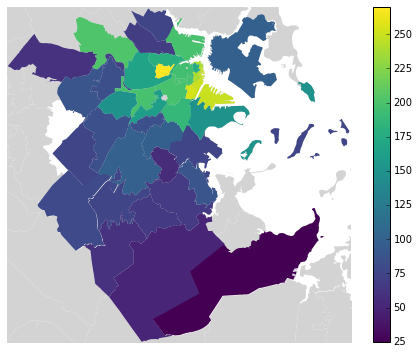

In [116]:
ax = gplt.polyplot(boston_zip_codes.geometry, projection=gcrs.AlbersEqualArea(),
                   facecolor='lightgray', edgecolor='gray', linewidth=0)
gplt.aggplot(listings, projection=gcrs.AlbersEqualArea(), hue='price',
             by='zipcode', geometry=boston_zip_codes.geometry, agg=np.median, ax=ax,
             linewidth=0)

In [137]:
import shapely

collisions = pd.read_csv("/Users/Honors/Desktop/geoplot-data/nyc_collisions/NYPD_Motor_Vehicle_Collisions_2016.csv", index_col=0)

def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return shapely.geometry.Point(0, 0)
    else:
        return shapely.geometry.Point(long, lat)

collisions = collisions[collisions["CONTRIBUTING FACTOR VEHICLE 1"].isin(['Failure to Yield Right-of-Way', 'Lost Consciousness'])]
collisions = gpd.GeoDataFrame(collisions, geometry=collisions.apply(pointify, axis='columns'))

collisions = collisions[collisions.geometry.map(lambda srs: not (srs.x == 0))]

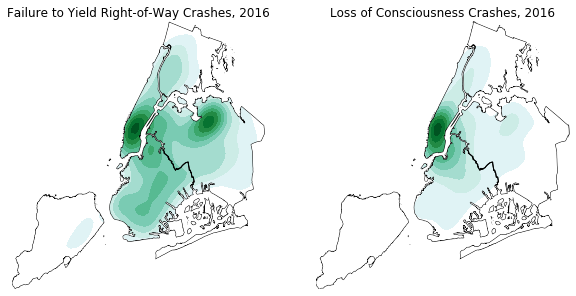

In [139]:
# Plot the data.
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121, projection=gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))

gplt.kdeplot(collisions[collisions["CONTRIBUTING FACTOR VEHICLE 1"] == 'Failure to Yield Right-of-Way'],
             projection=gcrs.AlbersEqualArea(), shade=True, clip=boroughs.geometry, shade_lowest=False, ax=ax1)
gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), ax=ax1)
plt.title("Failure to Yield Right-of-Way Crashes, 2016")

ax2 = plt.subplot(122, projection=gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))

gplt.kdeplot(collisions[collisions["CONTRIBUTING FACTOR VEHICLE 1"] == 'Lost Consciousness'],
             projection=gcrs.AlbersEqualArea(), shade=True, clip=boroughs.geometry, shade_lowest=False, ax=ax2)
gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), ax=ax2)
plt.title("Loss of Consciousness Crashes, 2016")

In [140]:
with open("nyc-collision-factors.geojson", "w") as f:
    f.write(collisions.to_json())

In [4]:
collisions = pd.read_csv("/Users/Honors/Desktop/geoplot-data/nyc-2016-traffic-collisions.csv", index_col=0)

In [8]:
from shapely.geometry import Point

def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return Point(0, 0)
    else:
        return Point(long, lat)
    
collisions = gpd.GeoDataFrame(collisions, geometry=collisions.apply(pointify, axis='columns'))
collisions = collisions[collisions.geometry.map(lambda srs: not (srs.x == 0))]
collisions = collisions[~collisions['ZIP CODE'].isin([10000, 10803, 11242])]

In [12]:
with open("nyc-collision-factors.geojson", "w") as f:
    f.write(collisions.loc[:, ['ZIP CODE', 'NUMBER OF PERSONS INJURED', 'geometry']].to_json())

In [1]:
import pandas as pd
# TODO: Regen the world flights data!
# TODO: Put up the Manhattan example somewhere else?
flights = pd.read_excel("/Users/Honors/Desktop/geoplot-data-old/world_flights/1000 Largest City Pairs by Number of Passengers.xlsx")

In [2]:
flights = flights.drop(0)

In [3]:
import geopy

flights.columns = ['Passengers', 'Passenger Miles', 'Origin - Destination']

In [4]:
pairs = flights['Origin - Destination'].map(lambda od: [c.strip().replace(" Total", "") for c in od.split("-")])

In [5]:
origins = []
destinations = []

for _, pair in pairs.iteritems():
    origins.append(pair[0])
    destinations.append(pair[1])
    
flights = flights.assign(Origin=origins, Destination=destinations)

In [6]:
la_flights = flights.query('Origin == "Los Angeles, CA"')

In [7]:
from shapely.geometry import Point
la_flights['Starting Point'] = [Point(-118.2437, 34.0522)]*len(la_flights)

/Users/Honors/anaconda/envs/geoplot/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
from tqdm import tqdm

In [9]:
from geopy import GoogleV3
geolocator = GoogleV3()
ends = [geolocator.geocode(v) for v in tqdm(la_flights['Destination'])]

100%|██████████| 42/42 [00:16<00:00,  2.15it/s]


In [10]:
ends2 = [Point((e.longitude, e.latitude)) for e in ends]

In [11]:
la_flights['Ending Point'] = ends2

/Users/Honors/anaconda/envs/geoplot/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


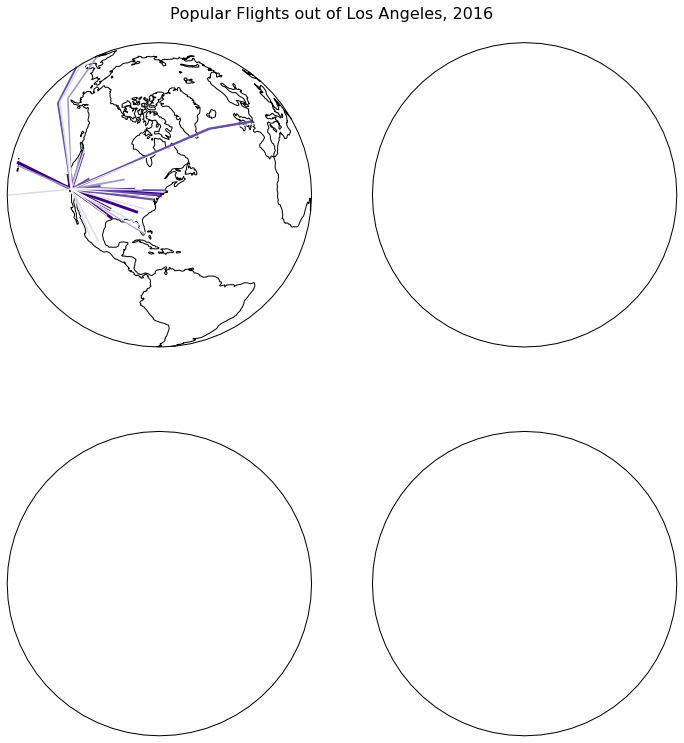

In [77]:
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import geoplot as gplt
%matplotlib inline

f, axarr = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={
    'projection': gcrs.Orthographic(central_latitude=40.7128, central_longitude=-74.0059)
})
plt.suptitle('Popular Flights out of Los Angeles, 2016', fontsize=16)
plt.subplots_adjust(top=0.95)

ax = gplt.sankey(la_flights, start='Starting Point', end='Ending Point',
                 projection=gcrs.Orthographic(), scale='Passengers', hue='Passengers', cmap='Purples', ax=axarr[0][0])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

In [13]:
la_flights = la_flights.drop(['Origin - Destination', 'Passenger Miles'], axis='columns')

In [18]:
la_flights.head()

,Passengers,Destination,Origin,Starting Point,Ending Point
3,1863155,"San Francisco, CA","Los Angeles, CA",POINT (-118.2437 34.0522),POINT (-122.4194155 37.7749295)
5,1698805,"New York, NY","Los Angeles, CA",POINT (-118.2437 34.0522),POINT (-74.00552449999999 40.7134248)
7,1600612,"Chicago, IL","Los Angeles, CA",POINT (-118.2437 34.0522),POINT (-87.6297982 41.8781136)
31,1244407,"Las Vegas, NV","Los Angeles, CA",POINT (-118.2437 34.0522),POINT (-115.1398296 36.1699412)
40,1164625,"Dallas/Fort Worth, TX","Los Angeles, CA",POINT (-118.2437 34.0522),POINT (-97.0403352 32.8998091)


In [22]:
from shapely.geometry import MultiPoint
import geopandas as gpd

la_flights_g = gpd.GeoDataFrame(
    la_flights, 
    geometry=la_flights.apply(lambda df: MultiPoint([df['Starting Point'], df['Ending Point']]), axis='columns')
).drop(['Starting Point', 'Ending Point'], axis='columns')

In [24]:
with open("la-flights.geojson", "w") as f:
    f.write(la_flights_g.to_json())

In [28]:
la_flights = gpd.read_file("la-flights.geojson")

In [33]:
la_flights = la_flights.assign(
    start=la_flights.geometry.map(lambda mp: mp[0]),
    end=la_flights.geometry.map(lambda mp: mp[1])
)

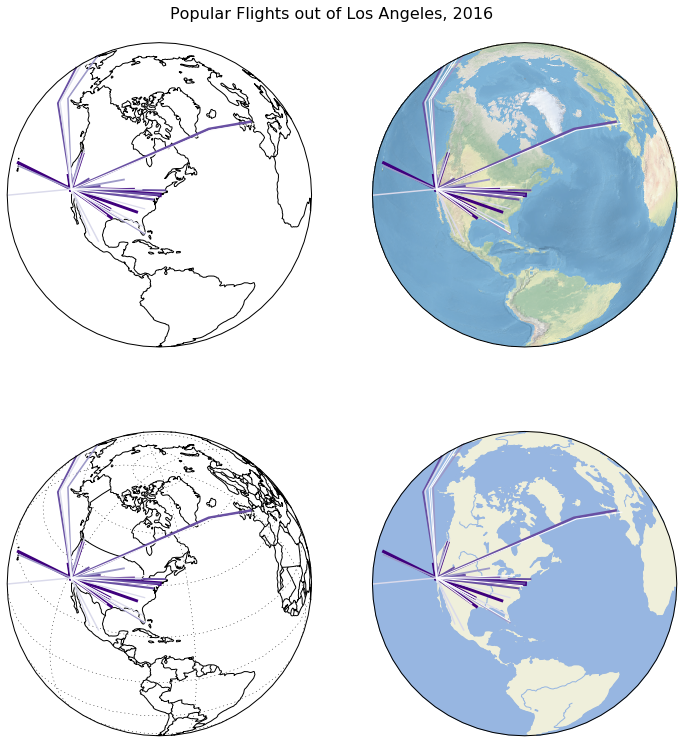

In [41]:
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import geoplot as gplt
import cartopy
%matplotlib inline

# Plot the data.
f, axarr = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={
    'projection': gcrs.Orthographic(central_latitude=40.7128, central_longitude=-74.0059)
})
plt.suptitle('Popular Flights out of Los Angeles, 2016', fontsize=16)
plt.subplots_adjust(top=0.95)

ax = gplt.sankey(la_flights, start='start', end='end',
                 projection=gcrs.Orthographic(), scale='Passengers', hue='Passengers', cmap='Purples', ax=axarr[0][0])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

ax = gplt.sankey(la_flights, start='start', end='end',
                 projection=gcrs.Orthographic(), scale='Passengers', hue='Passengers', cmap='Purples', ax=axarr[0][1])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.stock_img()

ax = gplt.sankey(la_flights, start='start', end='end',
                 projection=gcrs.Orthographic(), scale='Passengers', hue='Passengers', cmap='Purples', ax=axarr[1][0])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.gridlines()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

ax = gplt.sankey(la_flights, start='start', end='end',
                 projection=gcrs.Orthographic(), scale='Passengers', hue='Passengers', cmap='Purples', ax=axarr[1][1])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)

In [42]:
%ls

boston-airbnb.geojson               nyc-collision-factors.geojson
boston-zip-codes.geojson            nyc-fatal-collisions.geojson
build.ipynb                         nyc-injurious-collisions.geojson
contiguous-usa.geojson              nyc-parking-tickets-sample.geojson
dc-roads.geojson                    nyc-police-precincts.geojson
la-flights.geojson                  nyc-traffic-collisions.geojson
napolean-troop-movements.txt        obesity-by-state.tsv
nyc-boroughs.geojson                usa-cities.geojson
nyc-census-partial.geojson


And now zip this stuff up yourself!